<a href="https://colab.research.google.com/github/noe831/gitpractice/blob/master/notebooks/Chunking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enhanced Chunking and Vectorization with Docling


## Lab 2: Advanced Document Processing

In our previous workshop, you learned how to convert documents with Docling. Now, we'll tackle the next critical challenge: **how to intelligently chunk those documents for optimal retrieval in AI systems**. This is where many RAG implementations succeed or fail.

## Learning Objectives

By the end of this tutorial, you will:
- **Understand** why chunking is critical for RAG system performance
- **Compare** different chunking strategies and their trade-offs
- **Implement** hierarchical and hybrid chunking with Docling
- **Evaluate** chunk quality using practical metrics
- **Choose** the right chunking approach for your use case

## Prerequisites

- Python 3.11 or 3.12
- Basic understanding of RAG (Retrieval Augmented Generation) concepts
- Familiarity with text processing and embeddings

## What You'll Build

We'll create a complete document chunking pipeline that:
1. Processes PDF documents using Docling's advanced capabilities
2. Applies multiple chunking strategies with clear comparisons
3. Visualizes chunk characteristics for quality assessment
4. Provides actionable guidance for strategy selection
5. Prepares chunks for embedding and vector storage

More importantly, you'll gain the intuition to make informed chunking decisions for your own projects.

---

## Understanding Retrieval Augmented Generation (RAG) and Chunking's Critical Role


### What is RAG and Why Does It Matter?

[Retrieval-augmented generation (RAG)](https://www.ibm.com/think/topics/retrieval-augmented-generation) has emerged as the dominant pattern for building AI applications that need access to private or recent data. Unlike pure language models that rely solely on training data, RAG systems dynamically retrieve relevant information to generate accurate, grounded responses.

Think of RAG as giving an AI assistant access to a perfectly organized library. The quality of the organization (chunking) directly determines how well the assistant can find and use information.


### The RAG Pipeline: Where Chunking Fits

The complete RAG process involves six interconnected steps:

1. **Document Processing**: Converting raw documents (PDFs, Word, etc.) into structured formats
2. **Chunking**: Breaking documents into semantically meaningful pieces ← **Today's focus**
3. **Vectorization**: Converting text chunks into numerical embeddings
4. **Indexing**: Storing vectors in a specialized database for similarity search
5. **Retrieval**: Finding the most relevant chunks for a given query
6. **Generation**: Using retrieved context to generate accurate, grounded responses

### Why is Chunking Critical?

Chunking is arguably the most important yet underappreciated step in the RAG pipeline. Here's why:

#### 1. **Context Window Constraints**
Modern embedding models have strict token limits:
- IBM Granite embeddings: 512 tokens
- Cohere embed-v3: 512 tokens
- OpenAI's text-embedding-3-small: 8,191 tokens

Chunks must fit within these limits while preserving meaning.

#### 2. **Retrieval Precision vs. Recall Trade-off**
- **Small chunks**: High precision (exact matches) but may miss context
- **Large chunks**: Better context but lower precision (irrelevant content)

Finding the sweet spot is crucial for system performance.

#### 3. **Semantic Coherence**
Well-designed chunks maintain topical unity. A chunk about "quarterly revenue" shouldn't suddenly switch to "employee benefits" mid-way through.

#### 4. **Cost and Performance**
- Smaller chunks = More embeddings = Higher costs
- Larger chunks = Fewer embeddings but potentially worse retrieval

#### 5. **User Experience**
The quality of retrieved chunks directly impacts the relevance and accuracy of generated responses. Poor chunking leads to hallucinations, missing information, or irrelevant answers.


### The Chunking Challenge: A Practical Example

Let's illustrate why naive chunking fails and intelligent chunking succeeds:

**Bad Chunking Example (Fixed-size splitting):**
```
Chunk 1: "The company's revenue increased by 25% in Q3"
Chunk 2: "2024 compared to Q3 2023. This growth was driven by..."
```
**Problems**:
- Critical context (which year?) is split across chunks
- A search for "2024 revenue growth" might miss Chunk 1 entirely
- The model lacks complete information to answer accurately

**Good Chunking Example (Semantic-aware):**
```
Chunk 1: "Financial Performance Q3 2024: The company's revenue increased by
          25% in Q3 2024 compared to Q3 2023, reaching $1.2B in total sales."
          
Chunk 2: "Growth Drivers: This exceptional growth was driven by strong
          performance in the enterprise segment, with cloud services
          contributing 60% of the increase..."
```

**Benefits**:
- Complete, self-contained thoughts
- Clear topical boundaries
- Sufficient context for accurate retrieval
- Natural section breaks preserved

### What Makes a Good Chunk?

Before we dive into implementation, let's establish the characteristics of effective chunks:

1. **Self-contained**: Can be understood without external context
2. **Topically coherent**: Focuses on a single topic or concept
3. **Appropriately sized**: Fits within model limits with headroom
4. **Contextually rich**: Includes necessary metadata (source, section, page)
5. **Semantically complete**: Doesn't cut off mid-sentence or mid-thought

Now, let's use Docling's capabilities build a system that creates these ideal chunks automatically!

## Installation and Setup

Let's begin by setting up our environment with all necessary dependencies. We'll install not just Docling, but also the tools needed for chunking, vectorization, and evaluation.


In [13]:
import sys
assert sys.version_info >= (3, 11) and sys.version_info < (3, 13), "Use Python 3.11 or 3.12 to run this notebook."

In [2]:
! echo "::group::Install Dependencies"
%pip install uv
! uv pip install \
    transformers \
    pillow \
    docling \
    matplotlib
! echo "::endgroup::"

::group::Install Dependencies
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 80.9 MB/s eta 0:00:00
Using Python 3.12.12 environment at: /usr
Resolved 109 packages in 2.05s
Prepared 23 packages in 1.24s
Uninstalled 1 package in 2ms
Installed 23 packages in 159ms
 + colorlog==6.10.1
 + docling==2.58.0
 + docling-core==2.49.0
 + docling-ibm-models==3.10.1
 + docling-parse==4.7.0
 + faker==37.12.0
 + filetype==1.2.0
 + jsonlines==4.0.0
 + jsonref==1.1.0
 + latex2mathml==3.78.1
 + marko==2.2.1
 + mpire==2.10.2
 + polyfactory==2.22.3
 + pyclipper==1.3.0.post6
 + pylatexenc==2.10
 + pypdfium2==4.30.0
 + python-docx==1.2.0
 + python-pptx==1.0.2
 + rapidocr==3.4.2
 + rtree==1.4.1
 + semchunk==2.2.2
 - typer==0.20.0
 + typer==0.19.2
 + xlsxwriter==3.2.9
::endgroup::


Now let's import the essential modules:

In [3]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from typing import Iterator

### Logging

To see detailed information about the document processing and chunking operations, we'll configure INFO log level.

NOTE: It is okay to skip running this cell if you prefer less verbose output.

In [4]:
import logging

logging.basicConfig(level=logging.INFO)

## Document Processing with Docling

### Understanding Document Structure

Before we can chunk intelligently, we need to understand how Docling preserves document structure. This structural awareness is what separates naive text splitting from semantic chunking.

Let's start by processing a real document and exploring its structure:

In [5]:
from docling.document_converter import DocumentConverter, PdfFormatOption
from docling.datamodel.base_models import InputFormat
from docling.datamodel.pipeline_options import PdfPipelineOptions

# Configure pipeline to extract both text and images
pdf_pipeline_options = PdfPipelineOptions(
    do_ocr=False,   # Skip OCR for faster processing (enable for scanned docs)
    generate_picture_images=True,   # Extract images for multi-modal applications
)
format_options = {
    InputFormat.PDF: PdfFormatOption(pipeline_options=pdf_pipeline_options),
}
converter = DocumentConverter(format_options=format_options)

# Process a sample document
sample_doc_url = "https://midwestfoodbank.org/images/AR_2020_WEB2.pdf"
result = converter.convert(sample_doc_url)
doc = result.document

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


**Why this document?**
We're using an annual report because it contains:
- Hierarchical sections (perfect for testing structural chunking)
- Mixed content types (text, tables, images)
- Varying paragraph lengths (tests size-aware chunking)
- Real-world complexity (not a toy example)

### The Importance of Structure Preservation

Docling doesn't just extract text; it preserves the document's logical structure. This includes:
- **Headings and subheadings**: Natural chunk boundaries
- **Paragraphs**: Semantic units of thought
- **Lists and tables**: Special handling required
- **Captions and references**: Important context

This structural information is very important for intelligent chunking

---

## Chunk Visualization: See What You're Building

Before we dive into chunking strategies, let's build a powerful visualization tool. Being able to "see" your chunks is invaluable for understanding and debugging.


### Building a Comprehensive Chunk Analyzer

In [6]:
from docling_core.transforms.chunker.tokenizer.base import BaseTokenizer
from docling.chunking import BaseChunker, BaseChunk
from docling.datamodel.document import DoclingDocument

def visualize_chunks(chunks: list[BaseChunk], *, chunker: BaseChunker, tokenizer: BaseTokenizer, title="Document Chunks"):
    """Visualize chunk sizes and distribution in tokens.
    """
    # Extract token counts for each chunk
    token_counts = [tokenizer.count_tokens(chunker.contextualize(chunk=chunk)) for chunk in chunks]

    # Create histogram with all annotations in one go
    plt.figure(figsize=(10, 6))

    # Create the histogram
    plt.hist(token_counts, bins=20, alpha=0.7, color='skyblue')

    # Add statistics line and annotations
    avg_tokens = np.mean(token_counts)
    plt.axvline(avg_tokens, color='red', linestyle='--', label=f'Average: {avg_tokens:.1f}')

    # Add labels and formatting
    plt.title(title)
    plt.xlabel('Chunk Size (tokens)')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.legend()

    # Show the complete plot
    plt.show()

    # Print comprehensive statistics
    print(f"Chunk Analysis Results:")
    print(f"Total chunks: {len(token_counts)}")
    print(f"Average chunk size: {np.mean(token_counts):.1f} tokens")
    print(f"Minimum chunk size: {min(token_counts)} tokens")
    print(f"Maximum chunk size: {max(token_counts)} tokens")
    print(f"Standard deviation: {np.std(token_counts):.1f} tokens")

    # Quality indicators
    if max(token_counts) > 512:
        print("Warning: Some chunks exceed 512 tokens - consider reducing chunk size")
    if np.std(token_counts) > 100:
        print("Warning: High variance in chunk sizes - retrieval consistency may suffer")

    # Also show character length for reference
    char_lengths = [len(chunk.text) for chunk in chunks]
    print(f"\nReference - Average character length: {np.mean(char_lengths):.1f} characters")

## Docling Chunking Fundamentals: Understanding the Architecture

Before we explore specific strategies, let's understand Docling's chunking architecture. This knowledge will help you extend or customize chunking for your needs.


### The BaseChunker Interface

Docling defines a BaseChunker interface that all chunkers must implement. This interface includes two main methods:

1. `chunk(dl_doc)`: Returns an iterator of chunks for the provided document
2. `serialize(chunk)`: Returns the serialized representation of a chunk, typically used for embedding

Let's examine this interface:

In [7]:
# Example of BaseChunker interface structure
class SimpleChunker(BaseChunker):
    """A simple example chunker implementing the BaseChunker interface."""

    def chunk(self, dl_doc: DoclingDocument, **kwargs) -> Iterator[BaseChunk]:
        """Return chunks for the provided document."""
        # Simple implementation: one chunk per page
        for i, page in enumerate(dl_doc.pages):
            text = " ".join([item.text for item in page.items if hasattr(item, "text")])
            metadata = {
                "page": i,
                "source": dl_doc.name
            }
            yield BaseChunk(text=text, metadata=metadata)

    def serialize(self, chunk: BaseChunk) -> str:
        """Serialize a chunk for embedding."""
        # Simple serialization: just return the text
        return chunk.text

---

## Chunking Strategies Deep Dive

Now let's explore Docling's built-in chunking strategies. Each has its strengths and ideal use cases.


### Strategy 1: HierarchicalChunker - Respecting Document Structure

The HierarchicalChunker preserves the natural organization of documents by following sections, subsections, and paragraphs. This is ideal for structured documents like reports, manuals, and academic papers.

**When to use HierarchicalChunker:**
- Structured documents (reports, manuals, academic papers)
- When preserving document hierarchy is important
- Documents with clear section breaks

Avoid for: Chat logs, social media posts, unstructured text

In [8]:
# Import the tokenizer for HybridChunker
from transformers import AutoTokenizer
from docling_core.transforms.chunker.tokenizer.huggingface import HuggingFaceTokenizer
from docling_core.transforms.chunker.hierarchical_chunker import HierarchicalChunker

# Set up the tokenizer - using IBM Granite for this example
embeddings_model_path = "ibm-granite/granite-embedding-30m-english"
embeddings_tokenizer = HuggingFaceTokenizer(
    tokenizer=AutoTokenizer.from_pretrained(embeddings_model_path),
)

Token indices sequence length is longer than the specified maximum sequence length for this model (669 > 512). Running this sequence through the model will result in indexing errors


Generated 160 chunks with HierarchicalChunker


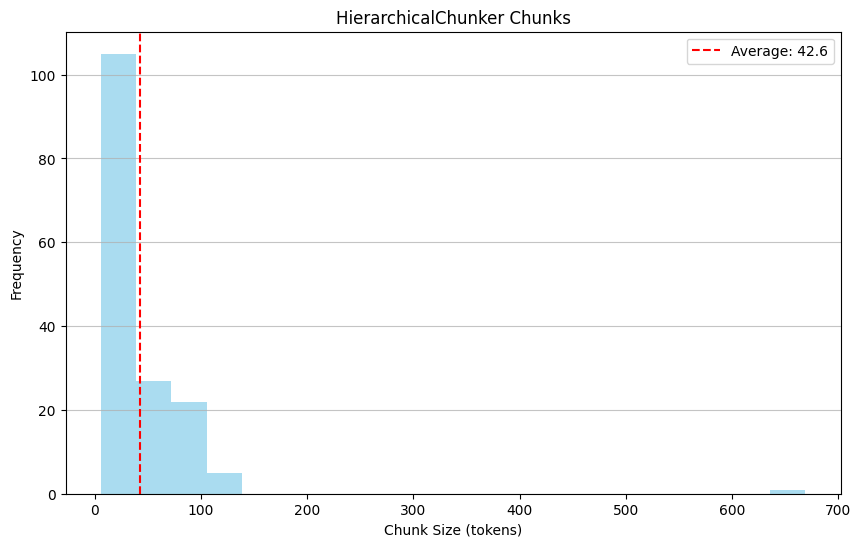

Chunk Analysis Results:
Total chunks: 160
Average chunk size: 42.6 tokens
Minimum chunk size: 6 tokens
Maximum chunk size: 669 tokens
Standard deviation: 57.5 tokens

Reference - Average character length: 135.8 characters

Sample Chunk Analysis:
Text (first 200 chars): All  MFB  locations  remained  open  and  responsive  to  the  need  of  our nonprofit partners. We enacted safety protocols and reduced volunteer numbers  to  maintain  social  distancing  guidelines...
Chunk type: DocChunk
Document metadata available in 'meta'
Meta preview: schema_name='docling_core.transforms.chunker.DocMeta' version='1.0.0' doc_items=[TextItem(self_ref='#/texts/5', parent=RefItem(cref='#/body'), children=[], content_layer=<ContentLayer.BODY: 'body'>, l...


In [9]:
# Create a HierarchicalChunker
hierarchical_chunker = HierarchicalChunker()

# Generate chunks
hierarchical_chunks = list(hierarchical_chunker.chunk(doc))

# Visualize the chunks
print(f"Generated {len(hierarchical_chunks)} chunks with HierarchicalChunker")
visualize_chunks(
    chunks=hierarchical_chunks,
    title="HierarchicalChunker Chunks",
    chunker=hierarchical_chunker,
    tokenizer=embeddings_tokenizer,
)

# Examine chunk structure
sample_chunk = hierarchical_chunks[2]
print(f"\nSample Chunk Analysis:")
print(f"Text (first 200 chars): {sample_chunk.text[:200]}...")
print(f"Chunk type: {type(sample_chunk).__name__}")

# Print available metadata
if hasattr(sample_chunk, 'dl_meta'):
    print("Document metadata available in 'dl_meta'")
elif hasattr(sample_chunk, 'meta'):
    print(f"Document metadata available in 'meta'")
    print(f"Meta preview: {str(sample_chunk.meta)[:200]}...")

### Strategy 2: HybridChunker - Balancing Structure and Size

The HybridChunker combines the best of both worlds: it starts with hierarchical chunking but then applies size-aware splitting and merging. This ensures chunks are neither too large nor too small.

**When to use HybridChunker:**
- Most production RAG systems (recommended default)
- When you need consistent chunk sizes
- Mixed document types in the same system
- When embedding model has strict token limits

HybridChunker Results:
Generated 73 chunks


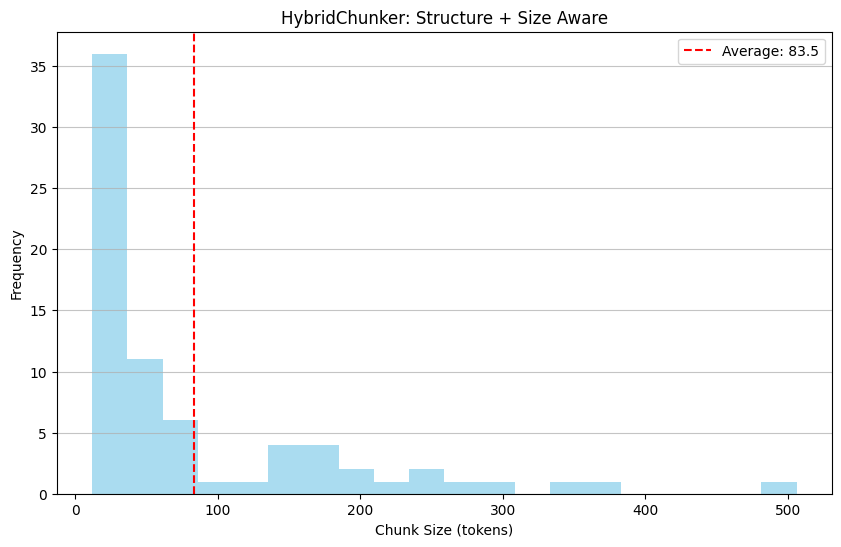

Chunk Analysis Results:
Total chunks: 73
Average chunk size: 83.5 tokens
Minimum chunk size: 12 tokens
Maximum chunk size: 506 tokens
Standard deviation: 98.2 tokens

Reference - Average character length: 298.9 characters

Strategy Comparison:
HierarchicalChunker: 160 chunks
HybridChunker: 73 chunks
Reduction: 54.4%

Sample HybridChunker Chunk:
Text (first 200 chars): bridging the gap between poverty and prosperity...
Metadata available - includes structural information


In [10]:

# Import HybridChunker
from docling_core.transforms.chunker.hybrid_chunker import HybridChunker

# Create a HybridChunker with default settings
hybrid_chunker = HybridChunker(
    tokenizer=embeddings_tokenizer,
)

# Generate chunks
hybrid_chunks = list(hybrid_chunker.chunk(doc))

# Analyze the results
print(f"HybridChunker Results:")
print(f"Generated {len(hybrid_chunks)} chunks")

visualize_chunks(
    chunks=hybrid_chunks,
    title="HybridChunker: Structure + Size Aware",
    chunker=hybrid_chunker,
    tokenizer=embeddings_tokenizer,
)

# Compare with HierarchicalChunker
print(f"\nStrategy Comparison:")
print(f"HierarchicalChunker: {len(hierarchical_chunks)} chunks")
print(f"HybridChunker: {len(hybrid_chunks)} chunks")
print(f"Reduction: {((len(hierarchical_chunks) - len(hybrid_chunks)) / len(hierarchical_chunks) * 100):.1f}%")

# Examine a sample chunk with context
sample_hybrid_chunk = hybrid_chunks[0]
print(f"\nSample HybridChunker Chunk:")
print(f"Text (first 200 chars): {sample_hybrid_chunk.text[:200]}...")

if hasattr(sample_hybrid_chunk, 'meta'):
    print(f"Metadata available - includes structural information")

## Advanced Configuration and Fine-Tuning

Now let's explore advanced configurations to optimize chunking for specific needs. The key is understanding how different parameters affect your results.


### Understanding the Impact of Chunk Size

Different chunk sizes serve different purposes. Let's explore how to configure HybridChunker for specific needs:

Token indices sequence length is longer than the specified maximum sequence length for this model (669 > 512). Running this sequence through the model will result in indexing errors


Advanced HybridChunker Results (64 token limit):
Generated 104 chunks


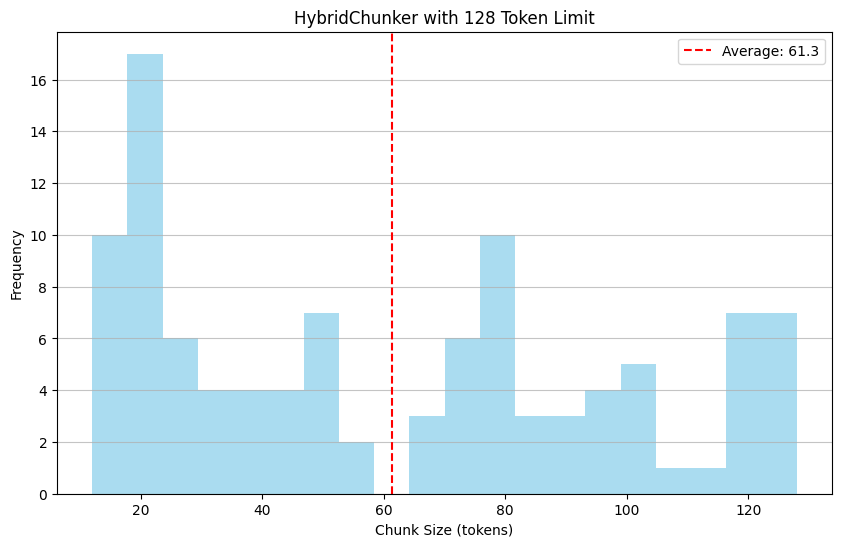

Chunk Analysis Results:
Total chunks: 104
Average chunk size: 61.3 tokens
Minimum chunk size: 12 tokens
Maximum chunk size: 128 tokens
Standard deviation: 37.3 tokens

Reference - Average character length: 209.5 characters


In [11]:
# Create a more constrained tokenizer for demonstration

max_tokens=128  # Smaller chunks for fine-grained retrieval

adv_tokenizer = HuggingFaceTokenizer(
    tokenizer=AutoTokenizer.from_pretrained(embeddings_model_path),
    max_tokens=max_tokens,
)

adv_chunker = HybridChunker(
    tokenizer=adv_tokenizer,
)

adv_chunks = list(adv_chunker.chunk(doc))

print(f"Advanced HybridChunker Results (64 token limit):")
print(f"Generated {len(adv_chunks)} chunks")

visualize_chunks(
    chunks=adv_chunks,
    title=f"HybridChunker with {max_tokens} Token Limit",
    chunker=adv_chunker,
    tokenizer=adv_tokenizer,
)

ℹ️ Note that the maximum chunk size is now 128, as expected.
Refer to Docling's [FAQ](https://docling-project.github.io/docling/faq/#hybridchunker-triggers-warning-token-indices-sequence-length-is-longer-than-the-specified-maximum-sequence-length-for-this-model) regarding the warning message _Token indices sequence length is longer than the specified maximum sequence length for this model (669 > 512)_.

### The Power of Contextualization

Another one of Docling's advanced features is contextualization - adding relevant surrounding information to chunks for better retrieval. Let's see it in action:


In [12]:
# Demonstrate contextualization - how chunks get additional context
print(f"\n Understanding Contextualization:")
print(f"Contextualization adds relevant surrounding information to improve retrieval quality.\n")

for i, chunk in enumerate(adv_chunks[:5]):
    tokens_text = adv_tokenizer.count_tokens(chunk.text)
    contextualized = adv_chunker.contextualize(chunk)
    tokens_contextualized = adv_tokenizer.count_tokens(contextualized)

    print(f"Chunk {i}:")
    print(f"Original text ({tokens_text} tokens): {chunk.text[:100]}...")
    print(f"Contextualized ({tokens_contextualized} tokens): {contextualized[:100]}...")
    print(f"Context added: {tokens_contextualized - tokens_text} tokens\n")


 Understanding Contextualization:
Contextualization adds relevant surrounding information to improve retrieval quality.

Chunk 0:
Original text (8 tokens): bridging the gap between poverty and prosperity...
Contextualized (13 tokens): ANNUAL REPORT 2020
bridging the gap between poverty and prosperity...
Context added: 5 tokens

Chunk 1:
Original text (54 tokens): No one could have predicted the events of 2020. The global COVID-19 pandemic created a dynamic year....
Contextualized (72 tokens): A message from Co-Founder, President, and CEO, David Kieser
No one could have predicted the events o...
Context added: 18 tokens

Chunk 2:
Original text (110 tokens): All  MFB  locations  remained  open  and  responsive  to  the  need  of  our nonprofit partners. We ...
Contextualized (128 tokens): A message from Co-Founder, President, and CEO, David Kieser
All  MFB  locations  remained  open  and...
Context added: 18 tokens

Chunk 3:
Original text (103 tokens): - MFB distributed a record amount 

---

### Choosing the Right Configuration

Here's a decision framework for chunk size selection:

#### Small Chunks (50-150 tokens)
**Use when:**
- You need precise fact retrieval
- Documents contain many discrete facts
- Storage cost is not a concern
- You have good reranking capabilities

**Example use cases:**
- FAQ systems
- Definition lookups
- Fact-checking applications

#### Medium Chunks (150-300 tokens)
**Use when:**
- Balancing precision and context
- Simple RAG systems
- Mixed query types
- Standard embedding models

**Example use cases:**
- Customer support systems
- Documentation search
- Knowledge management

#### Large Chunks (300-512+ tokens)
**Use when:**
- Context is crucial
- Narrative flow matters
- Fewer chunks preferred
- Cost optimization needed

**Example use cases:**
- Legal document analysis
- Research paper comprehension
- Story understanding


---

## Next Steps and Advanced Topics

Congratulations! You now understand the fundamentals of document chunking with Docling. Here's how to continue your journey:

### Next Steps:
1. **Try with your own documents**: Test different strategies on your specific content
2. **Optimize parameters**: Fine-tune chunk sizes based on your embedding model
3. **Integrate with vector databases**: Connect your chunking pipeline to Milvus, Pinecone, or similar

### Advanced Topics to Explore:
- **Custom chunking strategies**: Implement domain-specific chunking rules
- **Multi-modal chunking**: Handle documents with images and tables
- **Streaming chunking**: Process large document collections efficiently
- **Chunk overlap optimization**: Find the sweet spot for your retrieval quality
- **Semantic chunking**: Use embeddings to create semantically coherent chunks

### Resources for Further Learning:
- [Docling Documentation](https://docling-project.github.io/docling/)
- [RAG Best Practices Guide](https://python.langchain.com/docs/tutorials/rag/)
- [Chunking Strategies Research](https://arxiv.org/search/?query=text+chunking+retrieval)
